In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os,sys
from os import listdir
from os.path import isfile, join
import shutil
import imgaug
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import scipy
from skimage.morphology import convex_hull_image
# Root directory of the project
# todo: change to your path
ROOT_DIR = os.path.abspath("/Users/zhou/Mask_RCNN_Edit")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log
%matplotlib inline 
from IPython.display import set_matplotlib_formats
import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 320
mpl.rc("savefig", dpi=320)

/Users/zhou/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Functions of the process

In [2]:
def read_video(directory, sample_rate, preprosessing):
    cam = cv2.VideoCapture(directory)
    count_frame = 0
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(4, 4))
    index = 0

    image_list = []
    image_origin_list = []
    fgmask_list = []

    while True:
        ret, prev = cam.read()
        if not ret:
            break
        count_frame = count_frame + 1
        if count_frame % sample_rate == 0:
            image_origin_list.append( cv2.cvtColor( prev, cv2.COLOR_BGR2RGB ) )
            prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY )
            if preprosessing:
                image = clahe.apply(prevgray)
            # using Gaussian Blur is not good, tested
                image = cv2.GaussianBlur(image, (5, 5), 1)
            else:
                image = prevgray
            image_list.append(image)

            # image_stat= clahe.apply(image_stat)
            index = index + 1
    # change to np.float32, so that i will not overflow when doing subtraction
    return np.asarray(image_list, np.float32), image_origin_list


def calculate_image_mask(target_index, image_array, threshold_rate):

    image_diff = np.subtract(image_array[target_index,:,:], image_array)
    diff_image_array = np.abs(image_diff)
    diff_image_array = diff_image_array.tolist()
    del diff_image_array[target_index]
    diff_image_array = np.asarray(diff_image_array)
    # threshold the difference image.
    image_mean = np.mean(diff_image_array, axis=(1,2),dtype= np.float32)
    image_std = np.std(diff_image_array, axis=(1,2), dtype=np.float32)
    threshold_image_list = [diff_image_array[i,:,:] >= image_mean[i]+ 2*image_std[i] for i in range(diff_image_array.shape[0])]
    threshold_image_array = np.asarray(threshold_image_list)
    sum_diff_image = np.sum(threshold_image_array, axis = 0)
    # max_value = sum_diff_image.max()
    threshold_sum_diff = (sum_diff_image >= threshold_rate*threshold_image_array.shape[0])
    threshold_sum_diff = threshold_sum_diff.astype(np.uint8)
    return sum_diff_image, threshold_sum_diff


def display_details(threshold_image_array, image_origin_list):
    '''

    :param threshold_image_array: threshold_image_array = np.asarray(threshold_image_list)
    :param image_origin_list:
    :return: None
    '''
    for i in range(0, threshold_image_array.shape[0]):
        if i < target_index:
            plt.figure(i)
            plt.subplot(1,2,1)
            plt.imshow(threshold_image_array[i])
            # plt.colorbar()
            plt.subplot(1,2,2)
            plt.imshow(image_origin_list[i])
            plt.colorbar()
        else:
            plt.figure(i+1)
            plt.subplot(1, 2, 1 )
            plt.imshow(threshold_image_array[i] )
            # plt.colorbar()
            plt.subplot( 1, 2, 2 )
            plt.imshow(image_origin_list[i])
            plt.colorbar()


def morphlogical_process(threshold_sum_diff, open_iter=2,close_iter=3):
    # apply morphlogical operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
#     kernel1 = np.ones((3,3),np.uint8)
#     plt.figure("Comparason of threshold_sum_diff and new_threshold_sum_diff", figsize=(12, 14), dpi=80)

    # suppress noise using opening (erosion + dilation)
    opening = cv2.morphologyEx(threshold_sum_diff, cv2.MORPH_OPEN, kernel, iterations=open_iter)
    # fill the holes in forground (closing)
    # plt.figure("Opening result of morphlogical_process")
    # plt.imshow(opening, 'gray')
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=close_iter)
    # draw connected component
    src = closing
    src = np.asarray( src, np.uint8 )
    connectivity = 8
    # Perform the operation
    output = cv2.connectedComponents( src, connectivity, cv2.CV_32S )
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    labels = output[1]
    return num_labels, labels, closing

def display_process(target_index, image_list, sum_diff_image, threshold_sum_diff, closing):
#     plt.figure("Processing Display of Frame "  + str( target_index ),figsize=(12, 14), dpi=80)
#     plt.subplot( 2, 2, 1 )
    plt.figure()
#     plt.title( "Sample_Frame " + str( target_index ) )
    plt.imshow( image_list[target_index] )
    # plt.colorbar()
    
    
    plt.figure()
#     plt.subplot( 2, 2, 2 )
#     plt.title( "Summation of binary images" )
    plt.imshow( sum_diff_image, 'gray' )
    # plt.colorbar()

    
    plt.figure()
#     plt.subplot( 2, 2, 3 )
#     plt.title( "Binary image after threshold" )
    plt.imshow( threshold_sum_diff, 'gray' )
    
    
    plt.figure()
#     plt.subplot( 2, 2, 4 )
#     plt.title( "Applying Morphological Operation " )
    # plt.imshow(opening, 'gray')
    plt.imshow( closing, 'gray' )

def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width]. Mask pixels are either 1 or 0.

    Returns: bbox array [(y1, x1, y2, x2)].
    """
    boxes = np.zeros([1, 4], dtype=np.int32 )

    m = mask
        # Bounding box.
    horizontal_indicies = np.where( np.any( m, axis=0 ) )[0]
    vertical_indicies = np.where( np.any( m, axis=1 ) )[0]
    if horizontal_indicies.shape[0]:
        x1, x2 = horizontal_indicies[[0, -1]]
        y1, y2 = vertical_indicies[[0, -1]]
        # x2 and y2 should not be part of the box. Increment by 1.
        x2 += 1
        y2 += 1
        # else:
        #     # No mask for this instance. Might happen due to
        #     # resizing or cropping. Set bbox to zeros
        #     x1, x2, y1, y2 = 0, 0, 0, 0
        # boxes[i] = np.array( [y1, x1, y2, x2] )

    return np.abs(x2-x1), np.abs(y1-y2)


def show_final_mask(target_index, num_labels, labels, iter, kernel_size, show):
    kernel = cv2.getStructuringElement( cv2.MORPH_ELLIPSE, (kernel_size, kernel_size) )
    count = 0
    connect_components = []

    for i in range(1, num_labels):
        # robust to noise
        if not show:
            temp = labels == i
            temp = np.asarray(temp, dtype=np.uint8)
            component_after_closing = cv2.morphologyEx(temp, cv2.MORPH_DILATE, kernel, iterations=iter)
            connect_components.append( component_after_closing )
            count = count + 1

        else:
            if np.sum( labels == i ) >= 3000:
                temp = labels == i
                temp = np.asarray( temp, dtype=np.uint8 )
                component_after_closing = cv2.morphologyEx(temp, cv2.MORPH_ERODE, kernel, iterations=iter)

                if np.count_nonzero( component_after_closing ) >= 3000:
                    width, height = extract_bboxes(component_after_closing)
#                     print(np.int32(width*height))
#                     print("The Number of Pixels in Component {0} is {1}".format( count + 1, np.count_nonzero( component_after_closing ) ) )
                    if np.int32(width*height) >= 4000:
                        plt.figure( "Sample Frame " + str( target_index ) + ": Connected Components " + str( count + 1 ) ,figsize=(12, 14), dpi=80)
                        plt.title( "Sample Frame " + str( target_index ) + ": Connected Components " + str( count + 1 ) )
                        plt.imshow(component_after_closing, 'gray' )
                        print(np.int32(width*height))
                        print( "The Number of Pixels in Component {0} is {1}".format( count + 1, np.count_nonzero( component_after_closing ) ) )
                        connect_components.append( component_after_closing )
                        count = count + 1

    return count, connect_components
    
    
# def show_final_mask(target_index, num_labels, labels, iter, kernel_size, show):
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size,kernel_size))
#     count = 0
#     connect_components = []

#     for i in range(1, num_labels):
#         # robust to noise
#         if np.sum( labels == i ) >= 1000:

#             temp = labels == i
#             temp = np.asarray(temp, dtype=np.uint8)


#             # component_after_closing = cv2.morphologyEx(temp, cv2.MORPH_CLOSE, kernel, iterations=4)
#             if not show:
#                 component_after_closing = cv2.morphologyEx(temp, cv2.MORPH_DILATE, kernel, iterations=iter)
#             else:
#                 plt.figure( "Sample Frame " + str( target_index ) + ": Connected Components " + str( count + 1 ) ,figsize=(12, 14), dpi=80)
#                 plt.title( "Sample Frame " + str( target_index ) + ": Connected Components " + str( count + 1 ) )
#                 component_after_closing = cv2.morphologyEx(temp, cv2.MORPH_ERODE, kernel, iterations= iter)
#                 plt.imshow(component_after_closing, 'gray' )
#                 print( "The Number of Pixels in Component {0} is {1}".format( count + 1, np.sum( temp ) ) )

#             if np.count_nonzero( component_after_closing ) >= 1000:
#                 connect_components.append( component_after_closing )
#                 count = count + 1
#     return count, connect_components

def save_image(filename, target_index, image, mask, save_directory):
    '''

    :param self:
    :param image:
    :param mask:
    :param directory: directory to save video images
    :return:
    '''

    if not os.path.exists(save_directory):
        os.makedirs(save_directory )
    image = Image.fromarray(image)
    if not os.path.exists(os.path.join(save_directory, "RGB")):
        os.makedirs(os.path.join(save_directory, "RGB"))
    if not os.path.exists(os.path.join(save_directory, "Mask")):
        os.makedirs(os.path.join(save_directory, "Mask"))
    image.save(os.path.join(save_directory, "RGB", filename.split('.')[0] + "__Frame" + str(target_index) + '.png'))

    # np.uint8 is important. otherwise may cause error
    mask = mask.astype(np.uint8)
    for n in range(mask.shape[0]):
        binary_image = cv2.cvtColor(mask[n], cv2.COLOR_GRAY2BGR)*255
        mask_image = Image.fromarray(binary_image)
        mask_image.save(os.path.join(save_directory,"Mask",filename.split('.')[0] + "__Frame" + str(target_index) + "__CC" + str(n) +'.png'))

In [3]:
directory = "/Users/zhou/Desktop/data/video_clip/train/IMG_00000.MOV"
# image_origin_list ----grayscale
image_array, image_origin_list = read_video(directory, sample_rate=30, preprosessing=False)
print("We sample {0} frames from the video".format(image_array.shape[0]))
target_index = 42
sum_diff_image, threshold_sum_diff = calculate_image_mask(target_index, image_array, 0.6557)

We sample 61 frames from the video


In [4]:
threshold_rate = 0.65
image_diff = np.subtract(image_array[target_index,:,:], image_array)
diff_image_array = np.abs(image_diff)
diff_image_array = diff_image_array.tolist()
# del diff_image_array[target_index]
diff_image_array = np.asarray(diff_image_array)
# threshold the difference image.
image_mean = np.mean(diff_image_array, axis=(1,2),dtype= np.float32)
image_std = np.std(diff_image_array, axis=(1,2), dtype=np.float32)

(-0.5, 1919.5, 1079.5, -0.5)

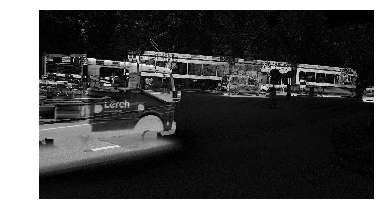

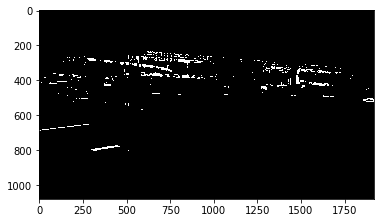

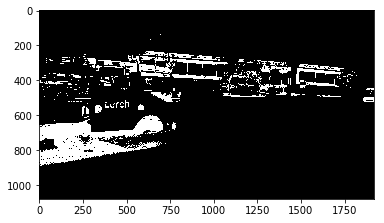

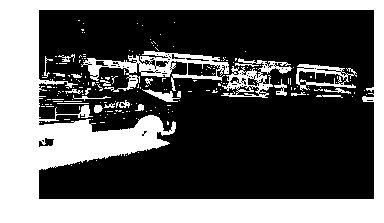

In [8]:
i=60
plt.figure()
plt.imshow(diff_image_array[i], 'gray')
plt.axis('off')
# plt.savefig('save_images/diff60.png')

threshold_image_list = [diff_image_array[i,:,:] >= image_mean[i]+ 3*image_std[i] for i in range(diff_image_array.shape[0])]
threshold_image_array = np.asarray(threshold_image_list)
plt.figure()
plt.imshow(threshold_image_array[i],'gray')

threshold_image_list = [diff_image_array[i,:,:] >= image_mean[i]+ 2*image_std[i] for i in range(diff_image_array.shape[0])]
threshold_image_array = np.asarray(threshold_image_list)
plt.figure()
plt.imshow(threshold_image_array[i],'gray')

threshold_image_list = [diff_image_array[i,:,:] >= image_mean[i]+ 1*image_std[i] for i in range(diff_image_array.shape[0])]
threshold_image_array = np.asarray(threshold_image_list)
plt.figure()
plt.imshow(threshold_image_array[i], 'gray')
plt.axis('off')
# plt.savefig('save_images/thre_diff5.png')

In [8]:
# sum_diff_image = np.sum(threshold_image_array, axis = 0)
# # max_value = sum_diff_image.max()
# threshold_sum_diff = (sum_diff_image >= threshold_rate*threshold_image_array.shape[0])
# threshold_sum_diff = threshold_sum_diff.astype(np.uint8)
# return sum_diff_image, threshold_sum_diff

# display normal process

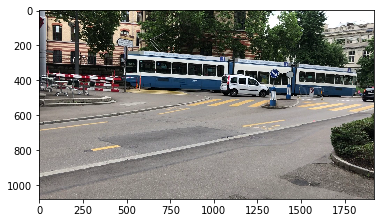

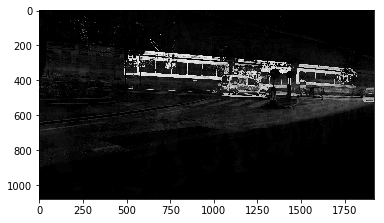

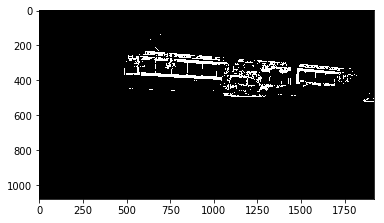

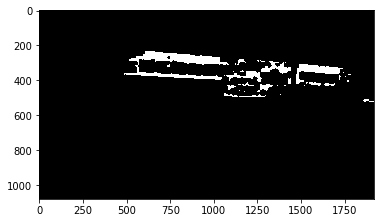

In [4]:
num_labels, labels, closing = morphlogical_process( threshold_sum_diff, open_iter=1,close_iter=4)
display_process(target_index, image_origin_list, sum_diff_image, threshold_sum_diff, closing)

In [5]:
def superpixel_based_processing( mask_image, orignal_image, rate, numSegments=1000, numCompactness=15):
    ## 1080*1920/900 = 2304
#     numSegments = 1000
    segments = slic(orignal_image, n_segments=numSegments, sigma=5, compactness=numCompactness)

    plt.figure( "Superpixels -- %d segments" % (numSegments),figsize=(12, 14), dpi=80 )
#     plt.subplot( 1, 2, 1 )
    plt.imshow(mark_boundaries( orignal_image, segments ) )
    plt.axis( "off" )
    plt.savefig('save_images/super-pixel_segment_image.png')
    for (i, segVal) in enumerate( np.unique( segments ) ):
        temp=mask_image[segments==segVal]
        frac = np.count_nonzero(temp)/len(temp)
        if frac >= rate:
            mask_image[segments == segVal]=1
        else:
            mask_image[segments == segVal]=0
    _, _, mask_image = morphlogical_process(mask_image, open_iter=2,close_iter=0)
    return mask_image



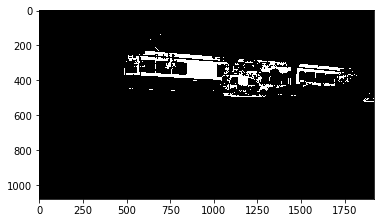

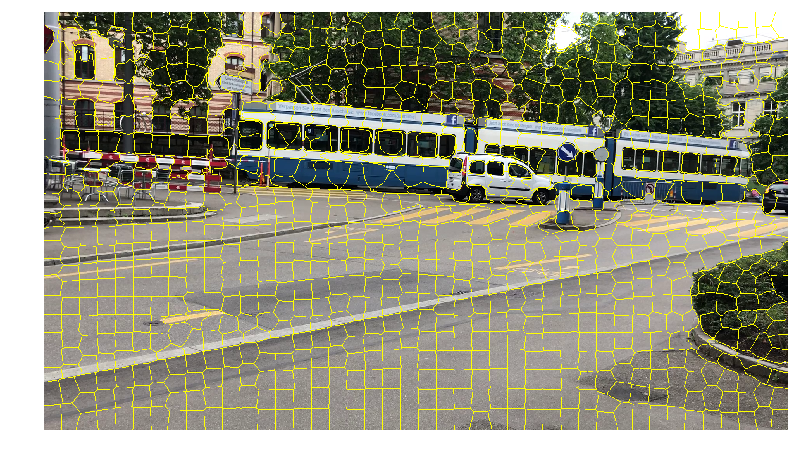

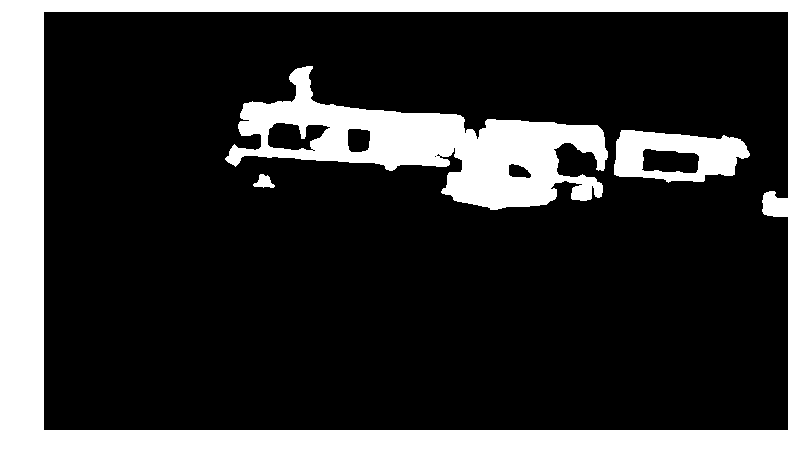

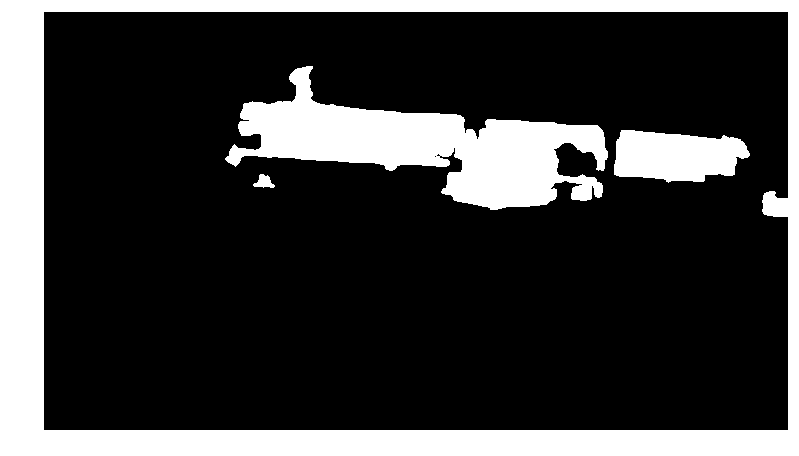

In [9]:
### for the threshold_sum_diff image, do the superpixel-based image processing, rate 
### should be small, rate = 0.2, to fill the missing parts, not too small to ignore nosie

threshold_sum_diff= scipy.ndimage.morphology.binary_fill_holes(threshold_sum_diff).astype(np.uint8)
plt.figure()
plt.imshow(threshold_sum_diff, 'gray')


closing_2 = threshold_sum_diff.copy()
mask_image2 = superpixel_based_processing(mask_image = closing_2, 
                                          orignal_image= image_origin_list[target_index],
                                          rate=0.05,numSegments=1000, numCompactness=25)

plt.figure(figsize=(12, 14), dpi=80)
# plt.subplot(1,2,2)
# plt.title('Mask image after superpixel processing: threshold_sum_diff')
plt.imshow(mask_image2, 'gray')
plt.axis('off')
plt.savefig('save_images/super-pixel_image.png')


mask_image2= scipy.ndimage.morphology.binary_fill_holes(mask_image2).astype(np.uint8)
plt.figure(figsize=(12, 14), dpi=80)
plt.imshow(mask_image2, 'gray')
plt.axis('off')
plt.savefig('save_images/super-pixel_image_fill_holes.png')

## Do opening and closing to remove noise and connect separete parts

In [10]:
num_labels1, labels1, closing1 = morphlogical_process(mask_image2, open_iter=0,close_iter=0)

# plt.figure(figsize=(12, 14), dpi=80)
# plt.imshow(closing1,'gray')


## Find CC parts and find convex hull for each, then add all the convex hull into one

505415
The Number of Pixels in Component 1 is 200899
4623
The Number of Pixels in Component 2 is 3698


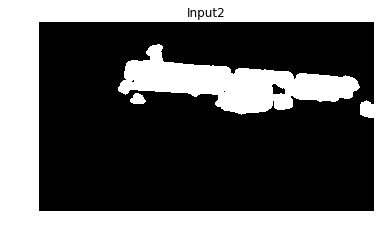

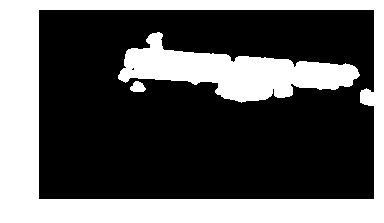

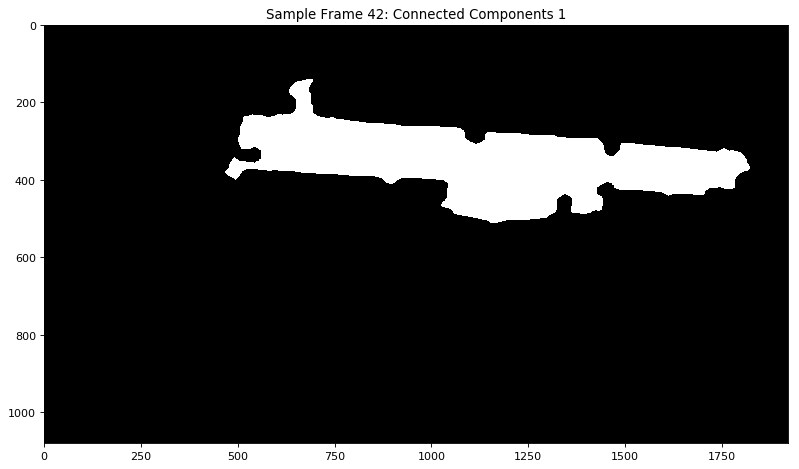

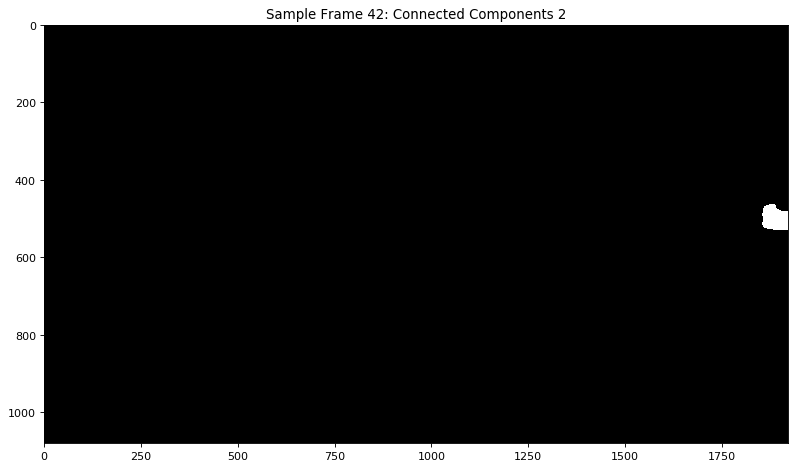

In [13]:
_, connect_components1 = show_final_mask(target_index, num_labels1, labels1, iter=5, kernel_size=7, show=False) 

connect_components_array = np.asarray( connect_components1, np.uint8 )
input2 = np.asarray( np.sum( connect_components_array, 0 ) > 0, np.uint8 )

plt.figure()
plt.title('Input2')
plt.imshow(input2, 'gray')
plt.axis('off')
plt.savefig('save_images/input2.png')


input2= scipy.ndimage.morphology.binary_fill_holes(input2).astype(np.uint8)

plt.figure()
# plt.title('Input2 after filling')
plt.imshow(input2, 'gray')
plt.axis('off')
plt.savefig('save_images/input2.png')




connectivity = 8
output1 = cv2.connectedComponents( input2, connectivity, cv2.CV_32S )
_, connect_components= show_final_mask( target_index, output1[0], output1[1], iter=5, kernel_size=7, show=True )


# connect_components_array1 = np.asarray( connect_components, np.uint8 )
# input3 = np.asarray( np.sum( connect_components_array1, 0 ) > 0, np.uint8 )

# plt.figure(figsize=(12, 14), dpi=80)
# plt.title('Input3')
# plt.imshow(input3, 'gray')
# plt.figure(figsize=(12, 14), dpi=80)
# plt.imshow( image_origin_list[target_index])


In [44]:
"""
Mask R-CNN
Display and Visualization Functions.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import os
import sys
import logging
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils


############################################################
#  Visualization
############################################################

def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interporlation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            x = random.randint(x1, (x1 + x2) // 2)
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
#         ax.imshow(tem)
#         plt.savefig('save_images/final.png')
        
    return masked_image.astype(np.uint8), ax
    
    
 
    


def display_differences(image,
                        gt_box, gt_class_id, gt_mask,
                        pred_box, pred_class_id, pred_score, pred_mask,
                        class_names, title="", ax=None,
                        show_mask=True, show_box=True,
                        iou_threshold=0.5, score_threshold=0.5):
    """Display ground truth and prediction instances on the same image."""
    # Match predictions to ground truth
    gt_match, pred_match, overlaps = utils.compute_matches(
        gt_box, gt_class_id, gt_mask,
        pred_box, pred_class_id, pred_score, pred_mask,
        iou_threshold=iou_threshold, score_threshold=score_threshold)
    # Ground truth = green. Predictions = red
    colors = [(0, 1, 0, .8)] * len(gt_match)\
           + [(1, 0, 0, 1)] * len(pred_match)
    # Concatenate GT and predictions
    class_ids = np.concatenate([gt_class_id, pred_class_id])
    scores = np.concatenate([np.zeros([len(gt_match)]), pred_score])
    boxes = np.concatenate([gt_box, pred_box])
    masks = np.concatenate([gt_mask, pred_mask], axis=-1)
    # Captions per instance show score/IoU
    captions = ["" for m in gt_match] + ["{:.2f} / {:.2f}".format(
        pred_score[i],
        (overlaps[i, int(pred_match[i])]
            if pred_match[i] > -1 else overlaps[i].max()))
            for i in range(len(pred_match))]
    # Set title if not provided
    title = title or "Ground Truth and Detections\n GT=green, pred=red, captions: score/IoU"
    # Display
    display_instances(
        image,
        boxes, masks, class_ids,
        class_names, scores, ax=ax,
        show_bbox=show_box, show_mask=show_mask,
        colors=colors, captions=captions,
        title=title)


def draw_rois(image, rois, refined_rois, mask, class_ids, class_names, limit=10):
    """
    anchors: [n, (y1, x1, y2, x2)] list of anchors in image coordinates.
    proposals: [n, 4] the same anchors but refined to fit objects better.
    """
    masked_image = image.copy()

    # Pick random anchors in case there are too many.
    ids = np.arange(rois.shape[0], dtype=np.int32)
    ids = np.random.choice(
        ids, limit, replace=False) if ids.shape[0] > limit else ids

    fig, ax = plt.subplots(1, figsize=(12, 12))
    if rois.shape[0] > limit:
        plt.title("Showing {} random ROIs out of {}".format(
            len(ids), rois.shape[0]))
    else:
        plt.title("{} ROIs".format(len(ids)))

    # Show area outside image boundaries.
    ax.set_ylim(image.shape[0] + 20, -20)
    ax.set_xlim(-50, image.shape[1] + 20)
    ax.axis('off')

    for i, id in enumerate(ids):
        color = np.random.rand(3)
        class_id = class_ids[id]
        # ROI
        y1, x1, y2, x2 = rois[id]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              edgecolor=color if class_id else "gray",
                              facecolor='none', linestyle="dashed")
        ax.add_patch(p)
        # Refined ROI
        if class_id:
            ry1, rx1, ry2, rx2 = refined_rois[id]
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal for easy visualization
            ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

            # Label
            label = class_names[class_id]
            ax.text(rx1, ry1 + 8, "{}".format(label),
                    color='w', size=11, backgroundcolor="none")

            # Mask
            m = utils.unmold_mask(mask[id], rois[id]
                                  [:4].astype(np.int32), image.shape)
            masked_image = apply_mask(masked_image, m, color)

    ax.imshow(masked_image)

    # Print stats
    print("Positive ROIs: ", class_ids[class_ids > 0].shape[0])
    print("Negative ROIs: ", class_ids[class_ids == 0].shape[0])
    print("Positive Ratio: {:.2f}".format(
        class_ids[class_ids > 0].shape[0] / class_ids.shape[0]))


# TODO: Replace with matplotlib equivalent?
def draw_box(image, box, color):
    """Draw 3-pixel width bounding boxes on the given image array.
    color: list of 3 int values for RGB.
    """
    y1, x1, y2, x2 = box
    image[y1:y1 + 2, x1:x2] = color
    image[y2:y2 + 2, x1:x2] = color
    image[y1:y2, x1:x1 + 2] = color
    image[y1:y2, x2:x2 + 2] = color
    return image


def display_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")


def plot_precision_recall(AP, precisions, recalls):
    """Draw the precision-recall curve.

    AP: Average precision at IoU >= 0.5
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1)
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    _ = ax.plot(recalls, precisions)


def plot_overlaps(gt_class_ids, pred_class_ids, pred_scores,
                  overlaps, class_names, threshold=0.5):
    """Draw a grid showing how ground truth objects are classified.
    gt_class_ids: [N] int. Ground truth class IDs
    pred_class_id: [N] int. Predicted class IDs
    pred_scores: [N] float. The probability scores of predicted classes
    overlaps: [pred_boxes, gt_boxes] IoU overlaps of predictins and GT boxes.
    class_names: list of all class names in the dataset
    threshold: Float. The prediction probability required to predict a class
    """
    gt_class_ids = gt_class_ids[gt_class_ids != 0]
    pred_class_ids = pred_class_ids[pred_class_ids != 0]

    plt.figure(figsize=(12, 10))
    plt.imshow(overlaps, interpolation='nearest', cmap=plt.cm.Blues)
    plt.yticks(np.arange(len(pred_class_ids)),
               ["{} ({:.2f})".format(class_names[int(id)], pred_scores[i])
                for i, id in enumerate(pred_class_ids)])
    plt.xticks(np.arange(len(gt_class_ids)),
               [class_names[int(id)] for id in gt_class_ids], rotation=90)

    thresh = overlaps.max() / 2.
    for i, j in itertools.product(range(overlaps.shape[0]),
                                  range(overlaps.shape[1])):
        text = ""
        if overlaps[i, j] > threshold:
            text = "match" if gt_class_ids[j] == pred_class_ids[i] else "wrong"
        color = ("white" if overlaps[i, j] > thresh
                 else "black" if overlaps[i, j] > 0
                 else "grey")
        plt.text(j, i, "{:.3f}\n{}".format(overlaps[i, j], text),
                 horizontalalignment="center", verticalalignment="center",
                 fontsize=9, color=color)

    plt.tight_layout()
    plt.xlabel("Ground Truth")
    plt.ylabel("Predictions")


def draw_boxes(image, boxes=None, refined_boxes=None,
               masks=None, captions=None, visibilities=None,
               title="", ax=None):
    """Draw bounding boxes and segmentation masks with differnt
    customizations.

    boxes: [N, (y1, x1, y2, x2, class_id)] in image coordinates.
    refined_boxes: Like boxes, but draw with solid lines to show
        that they're the result of refining 'boxes'.
    masks: [N, height, width]
    captions: List of N titles to display on each box
    visibilities: (optional) List of values of 0, 1, or 2. Determine how
        prominant each bounding box should be.
    title: An optional title to show over the image
    ax: (optional) Matplotlib axis to draw on.
    """
    # Number of boxes
    assert boxes is not None or refined_boxes is not None
    N = boxes.shape[0] if boxes is not None else refined_boxes.shape[0]

    # Matplotlib Axis
    if not ax:
        _, ax = plt.subplots(1, figsize=(12, 12))

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    margin = image.shape[0] // 10
    ax.set_ylim(image.shape[0] + margin, -margin)
    ax.set_xlim(-margin, image.shape[1] + margin)
    ax.axis('off')

    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        # Box visibility
        visibility = visibilities[i] if visibilities is not None else 1
        if visibility == 0:
            color = "gray"
            style = "dotted"
            alpha = 0.5
        elif visibility == 1:
            color = colors[i]
            style = "dotted"
            alpha = 1
        elif visibility == 2:
            color = colors[i]
            style = "solid"
            alpha = 1

        # Boxes
        if boxes is not None:
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=alpha, linestyle=style,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Refined boxes
        if refined_boxes is not None and visibility > 0:
            ry1, rx1, ry2, rx2 = refined_boxes[i].astype(np.int32)
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal
            if boxes is not None:
                ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

        # Captions
        if captions is not None:
            caption = captions[i]
            # If there are refined boxes, display captions on them
            if refined_boxes is not None:
                y1, x1, y2, x2 = ry1, rx1, ry2, rx2
            x = random.randint(x1, (x1 + x2) // 2)
            ax.text(x1, y1, caption, size=11, verticalalignment='top',
                    color='w', backgroundcolor="none",
                    bbox={'facecolor': color, 'alpha': 0.5,
                          'pad': 2, 'edgecolor': 'none'})

        # Masks
        if masks is not None:
            mask = masks[:, :, i]
            masked_image = apply_mask(masked_image, mask, color)
            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))


def display_table(table):
    """Display values in a table format.
    table: an iterable of rows, and each row is an iterable of values.
    """
    html = ""
    for row in table:
        row_html = ""
        for col in row:
            row_html += "<td>{:40}</td>".format(str(col))
        html += "<tr>" + row_html + "</tr>"
    html = "<table>" + html + "</table>"
    IPython.display.display(IPython.display.HTML(html))


def display_weight_stats(model):
    """Scans all the weights in the model and returns a list of tuples
    that contain stats about each weight.
    """
    layers = model.get_trainable_layers()
    table = [["WEIGHT NAME", "SHAPE", "MIN", "MAX", "STD"]]
    for l in layers:
        weight_values = l.get_weights()  # list of Numpy arrays
        weight_tensors = l.weights  # list of TF tensors
        for i, w in enumerate(weight_values):
            weight_name = weight_tensors[i].name
            # Detect problematic layers. Exclude biases of conv layers.
            alert = ""
            if w.min() == w.max() and not (l.__class__.__name__ == "Conv2D" and i == 1):
                alert += "<span style='color:red'>*** dead?</span>"
            if np.abs(w.min()) > 1000 or np.abs(w.max()) > 1000:
                alert += "<span style='color:red'>*** Overflow?</span>"
            # Add row
            table.append([
                weight_name + alert,
                str(w.shape),
                "{:+9.4f}".format(w.min()),
                "{:+10.4f}".format(w.max()),
                "{:+9.4f}".format(w.std()),
            ])
    display_table(table)

image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1080, 1920, 2)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  uint8
bbox                     shape: (2, 4)                min:  141.00000  max: 1920.00000  int32


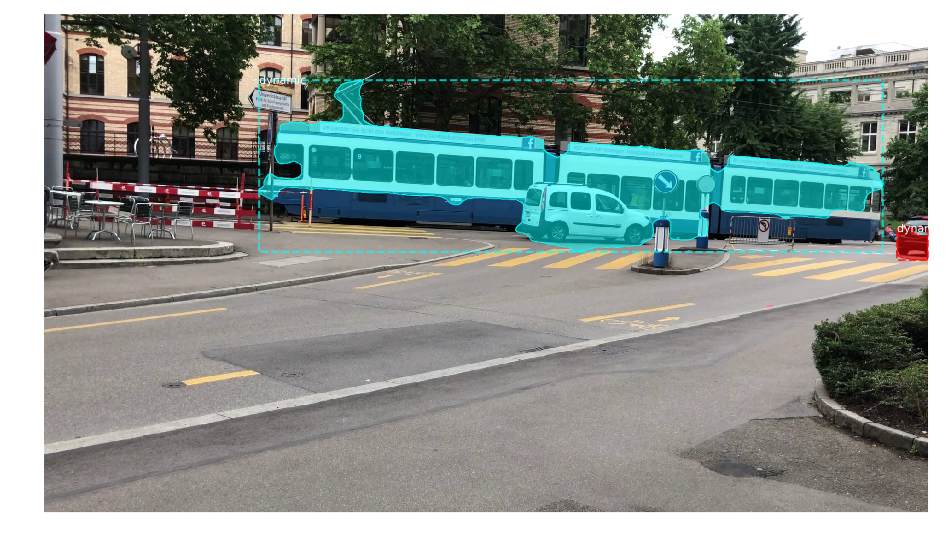

In [45]:
mask_ = np.expand_dims(np.asarray(connect_components, np.bool),axis=-1)
mask_ = np.swapaxes(mask_, axis1=0, axis2=3)
image = image_origin_list[target_index]
mask = np.squeeze(mask_,axis=0)
class_ids = np.ones([mask.shape[-1]], np.uint8)

bbox = utils.extract_bboxes(mask)
class_names = ['static', 'dynamic']
# Display image and additional stats
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
# visualize.display_instances(image, bbox, mask, class_ids, class_names )
tem ,ax= display_instances(image_origin_list[target_index],bbox, mask, class_ids, class_names)
ax.imshow(tem)
# image = Image.fromarray(tem)
# ax.save("/Users/zhou/Desktop/video_images/" + str(target_index) +'.png')
plt.savefig('gg.png')

In [36]:
from PIL import Image
image = Image.fromarray(tem)
image.save('save_images/final.png')